<a href="https://colab.research.google.com/github/viniciusdeavila/PUC-RIO-MVP-S2/blob/main/MPV_Sprint2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PARTE I - Modelo de Machine Learning**

# **1. Definição do Problema**

O objetivo deste trabalho é treinar um modelo de Machine Learning para classificação do estado fetal a partir da análise de cardiotocogramas.

De forma geral, o exame de cardiotocografia detecta a frequência cardíaca do feto e as contrações uterinas da mãe e, por meio de um registro gráfico, permite a avaliação do bem-estar materno-fetal.

# **2. Conjunto de Dados**

Para realização deste trabalho, foi utilizado o conjunto de dados Cardiotocografia, criado por D. Campos e J. Bernardes, obtido no repositório da UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/). Esse conjunto de dados possui licença Creative Commons Attribution, que permite o compartilhamento e a adaptação dos dados para qualquer finalidade, desde que seja dado o devido crédito.

Assim, serão carregados os dados do arquivo Excel "Cardiotocografia.xlsx", que possui os seguintes campos:

*   **LB** - FCF basal (batimentos por minuto)

*   **AC** - Número de acelerações por segundo

*   **FM** - Número de movimentos fetais por segundo

*   **RCU** - Número de contrações uterinas por segundo

*   **DL** - Número de desacelerações leves por segundo

*   **DS** - Número de desacelerações severas por segundo

*   **DP** - Número de desacelerações prolongadas por segundo

*   **ASTV** - Porcentagem de tempo com variabilidade anormal em curto prazo

*   **MSTV** - Valor médio da variabilidade de curto prazo

*   **ALTV** - Porcentagem de tempo com variabilidade anormal a longo prazo

*   **MLTV** - Valor médio da variabilidade a longo prazo

*   **Largura** - Largura do histograma FHR

*   **Min** - Mínimo do histograma da FCF

*   **Max** - Máximo do histograma de FCF

*   **Nmax** - Número de picos de histograma

*   **Nzeros** - Número de zeros do histograma

*   **Modo** - Modo histograma

*   **Media** - Média do histograma

*   **Mediana** - Mediana do histograma

*   **Variancia** - Variância do histograma

*   **Tendencia** - Tendência do histograma (-1 = assimétrica à esquerda; 0 = simétrica; 1 = assimétrica à direita)

*   **PNE** - Código de classe do estado fetal (N = normal; S = suspeito; P = patológico)

# **3. Importação das Bibliotecas e Carregamento dos Dados**

In [ ]:
# Inbir a exibição de warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
# Carregar arquivo Excel com o conjunto de dados Cardiotocografia
url = 'https://raw.githubusercontent.com/viniciusdeavila/puc-rio-mvp-s2/main/cardiotocografia.xlsx'
colunas = ['LB','AC','FM','RCU','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Largura','Min','Max','Nmax','Nzeros','Modo','Media','Mediana','Variancia','Tendencia','PNE']
df = pd.read_excel(url, names = colunas)
df = df.rename(columns = {'PNE': 'target'}) # definição da coluna target
df.head()

,LB,AC,FM,RCU,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Modo,Media,Mediana,Variancia,Tendencia,target
0,120,0,0,0,0,0,0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,S
1,132,4,0,4,2,0,0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,N
2,133,2,0,5,2,0,0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,N
3,134,2,0,6,2,0,0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,N
4,132,4,0,5,0,0,0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,N


Observa-se acima que o conjunto de dados apresenta colunas com alguns cálculos estatísticos como moda, mediana e variância, assim como algumas medidas como mínimo e máximo, que serão desconsideradas, a fim de não comprometer o treinamento do modelo.

Assim, para continuidade do trabalho, utilizaremos o DataFrame a seguir, contendo apenas os registros das marcações coletadas nos exames.

In [ ]:
# Selecionar colunas do DataFrame
df = df.loc[:, ['LB','AC','FM','RCU','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','target']]
df.head()

,LB,AC,FM,RCU,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,target
0,120,0,0,0,0,0,0,73,0.5,43,2.4,S
1,132,4,0,4,2,0,0,17,2.1,0,10.4,N
2,133,2,0,5,2,0,0,16,2.1,0,13.4,N
3,134,2,0,6,2,0,0,16,2.4,0,23.0,N
4,132,4,0,5,0,0,0,16,2.4,0,19.9,N


# **4. Preparação dos Dados**

Após definição do DataFrame, os dados foram separados em conjuntos de treino e teste, utilizando-se o método Holdout.

In [ ]:
# Separação em bases de treino e teste (holdout)
array = df.values
X = array[:,0:11] # atributos
y = array[:,11] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=29, stratify=y) # Holdout com estratificação

# Criação dos folds para validação cruzada (10 folds)
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=29) # Validação cruzada com estratificação

Para seleção dos recursos mais relevantes foram testados três algoritmos de Feature Selection (SelectKBest, Eliminação Recursiva de Atributos e Importância de Atributos com ExtraTrees) que, no entanto, não proporcionaram melhoria nos resultados observados.

Dessa forma, as linhas de código a seguir, referentes aos testes de Features Selection realizados, serão comentadas e apresentadas apenas como memória do trabalho realizado.

In [ ]:
## Importar bibliotecas
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
## SelectKBest

## Seleção de atributos com SelectKBest
# best_var = SelectKBest(score_func=f_classif, k=4)

## Executa a função de pontuação em (X, y) e obtém os atributos selecionados
#fit = best_var.fit(X, y)

## Reduz X para os atributos selecionados
#features = fit.transform(X)

## Resultados
#print('\nNúmero original de atributos:', X.shape[1])
#print('\nNúmero reduzido de atributos:', features.shape[1])

## Exibe os atributos orginais
#print("\nAtributos Originais:", df.columns[0:11])

## Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
#np.set_printoptions(precision=3) # 3 casas decimais
#print("\nScores dos Atributos Originais:", fit.scores_)
#print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=df.columns[0:11]))


Número original de atributos: 11

Número reduzido de atributos: 4

Atributos Originais: Index(['LB', 'AC', 'FM', 'RCU', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV'],
      dtype='object')

Scores dos Atributos Originais: [140.621 167.89    5.025  61.295  72.205  28.448 539.497 343.82  119.882
 345.156  70.174]

Atributos Selecionados: ['AC' 'DP' 'ASTV' 'ALTV']


In [ ]:
## Eliminação Recursiva de Atributos

## Criação do modelo
#modelo = LogisticRegression(max_iter=200)

## Eliminação Recursiva de Atributos
#rfe = RFE(modelo, n_features_to_select=4)
#fit = rfe.fit(X, y)

## Print dos resultados
#print("Atributos Originais:", df.columns[0:11])

## Exibe os atributos selecionados (marcados como True em "Atributos Selecionados"
## e com valor 1 em "Ranking dos Atributos")
#print("\nAtributos Selecionados: %s" % fit.support_)
#print("\nRanking de atributos: %s" % fit.ranking_)
#print("\nQtd de melhores Atributos: %d" % fit.n_features_)
#print("\nNomes dos Atributos Selecionados: %s" % fit.get_feature_names_out(input_features=df.columns[0:11]))

Atributos Originais: Index(['LB', 'AC', 'FM', 'RCU', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV'],
      dtype='object')

Atributos Selecionados: [False  True False False False  True  True False  True False False]

Ranking de atributos: [6 1 8 2 4 1 1 5 1 7 3]

Qtd de melhores Atributos: 4

Nomes dos Atributos Selecionados: ['AC' 'DS' 'DP' 'MSTV']


In [ ]:
## Importância de Atributos com ExtraTrees

## Criação do modelo para seleção de atributos
#modelo = ExtraTreesClassifier(n_estimators=100)
#modelo.fit(X,y)

## Exibe os atributos orginais
#print("\nAtributos Originais:", df.columns[0:11])

## Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
#print(modelo.feature_importances_)


Atributos Originais: Index(['LB', 'AC', 'FM', 'RCU', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV'],
      dtype='object')
[0.1   0.076 0.041 0.074 0.032 0.008 0.124 0.178 0.107 0.185 0.076]


# **5. Modelagem e Inferência**

### 5.1. Criação e Avalição de Modelos Linha de Base

A seguir, modelos de linha de base, com dados não padronizados e não normalizados, serão criados, testados e comparados para uma primeira análise.

LR: 0.877059 (0.020789)
KNN: 0.907647 (0.010206)
CART: 0.918235 (0.013783)
NB: 0.834706 (0.038072)
SVM: 0.835882 (0.019589)
Bagging: 0.934706 (0.022392)
RF: 0.942941 (0.022484)
ET: 0.935294 (0.016002)
Ada: 0.871765 (0.034178)
GB: 0.943529 (0.015828)
Voting: 0.894706 (0.011602)


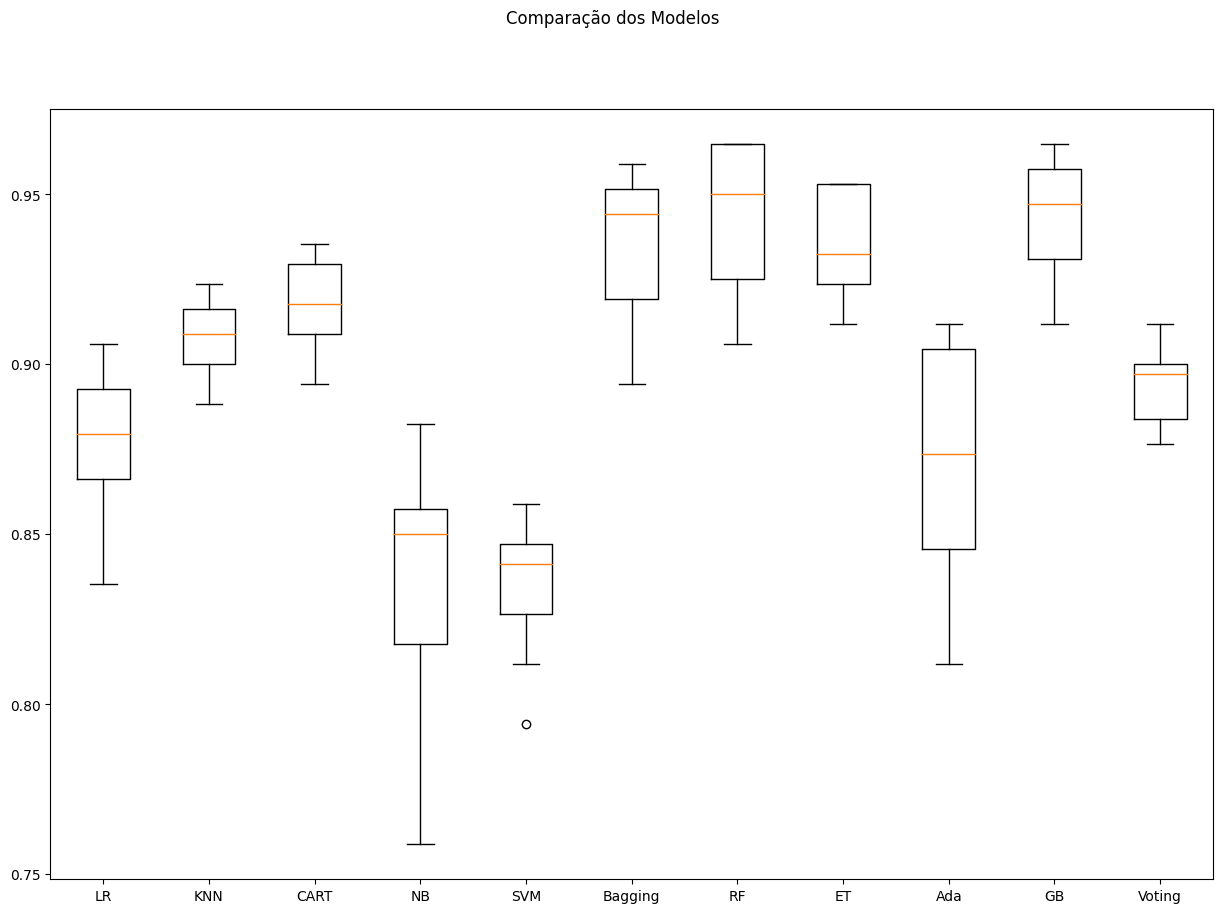

In [ ]:
# Criar modelos de linha de base
np.random.seed(29)
models = []

models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definir parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criar modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criar ensembles
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Avaliar os modelos criados
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Gerar gráfico de Boxplot para comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Em uma primeira análise, observa-se que os modelos Gradient Boosting (GB), Random Forest (RF) e Extra Trees (ET) foram os que apresentaram melhores resultados, com acurácia de 0.943, 0.942 e 0.935, respectivamente.

### 5.2. Criação e Avaliação de Modelos Padronizados e Normalizados

A seguir, serão criados e testados modelos com dados padronizados e normalizados, para uma nova análise e comparação com os modelos de linha de base.

LR-orig: 0.877 (0.021)
KNN-orig: 0.908 (0.010)
CART-orig: 0.918 (0.014)
NB-orig: 0.835 (0.038)
SVM-orig: 0.836 (0.020)
Bag-orig: 0.935 (0.022)
RF-orig: 0.943 (0.022)
ET-orig: 0.935 (0.016)
Ada-orig: 0.872 (0.034)
GB-orig: 0.944 (0.016)
Vot-orig: 0.895 (0.012)
LR-padr: 0.885 (0.030)
KNN-padr: 0.908 (0.019)
CART-padr: 0.914 (0.013)
NB-padr: 0.837 (0.034)
SVM-padr: 0.905 (0.024)
Bag-padr: 0.931 (0.019)
RF-padr: 0.944 (0.018)
ET-padr: 0.937 (0.017)
Ada-padr: 0.872 (0.034)
GB-padr: 0.944 (0.016)
Vot-padr: 0.909 (0.021)
LR-norm: 0.878 (0.030)
KNN-norm: 0.911 (0.013)
CART-norm: 0.916 (0.011)
NB-norm: 0.837 (0.036)
SVM-norm: 0.899 (0.025)
Bag-norm: 0.934 (0.019)
RF-norm: 0.941 (0.021)
ET-norm: 0.934 (0.013)
Ada-norm: 0.872 (0.034)
GB-norm: 0.943 (0.015)
Vot-norm: 0.903 (0.024)


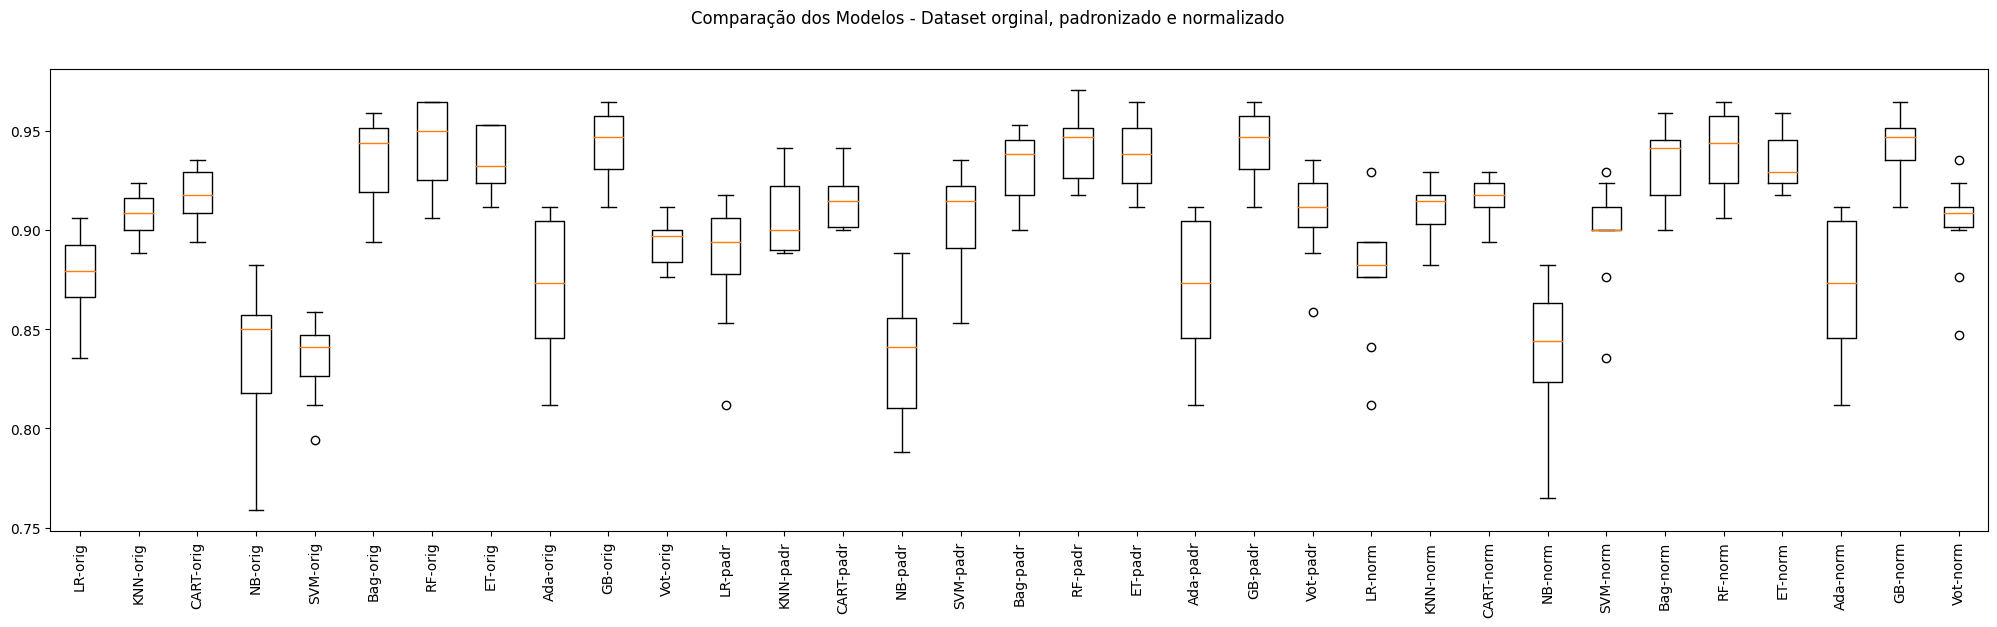

In [ ]:
# Criar modelos padronizados e normalizados
np.random.seed(29)

pipelines = []
results = []
names = []

# Configurar algoritmos
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Configurar as transformações de padronização e normalização
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montar pipelines para os modelos originais, padronizados e normalizados

# Modelos Originais
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Modelos Padronizados
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Modelos Normalizados
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executar os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Gerar gráfico de Boxplot para comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Após análise dos novos resultados, observa-se que os modelos Random Forest Padronizado (RF-padr) e Gradient Boosting Origianl (GB-orig) apresentaram os melhores resultados dentre todos os modelos testados, ambos com acurácia de 0.944.

### 5.3. Otimização de Hiperparâmetros

Definidos os dois melhores modelos para treinamento do conjunto de dados em questão, Random Forest Padronizado e Gradient Boosting Original, serão executados, a seguir, algoritmos para definição de hiperparâmetros para esses modelos, buscando sua otimização.

In [ ]:
# Otimização do Modelo Random Forest Padronizado

standard_scaler = StandardScaler().fit(X_train)
standardizedX = standard_scaler.transform(X_train)

model = RandomForestClassifier(random_state = 29)
model.fit(standardizedX, y_train)

y_pred = model.predict(X_test)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth':[8, 9, 10],
    'max_features': [1, 3, 5],
    'criterion': ['gini', 'entropia', 'log_loss'],
    'bootstrap': [True, False],
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = kfold, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 9, 'max_features': 3, 'n_estimators': 150}
0.9470588235294117


In [ ]:
# Otimização do Gradient Boosting Original

model = GradientBoostingClassifier(random_state = 29)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth':[5, 6, 7],
    'max_features': [1, 3, 5],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = kfold, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'friedman_mse', 'loss': 'deviance', 'max_depth': 6, 'max_features': 3, 'n_estimators': 150}
0.95


Conforme resultados visualizados, há melhora na acurácia de ambos os modelos com a adoção dos hiperparâmetros apresentados acima, sendo o modelo Gradient Boosting Original o que apresentou melhor resultado dentre os dois, com acurácia de 0.95.

Assim, o Gradient Boosting Original será o modelo escolhido para treinamento e avaliação com o conjunto de testes e, posteriormente, preparação com todo o DataFrame.

### 5.4. Finalização do Modelo

Para finalização do modelo, o Gradient Boosting Original será configurado com os hiperparâmetros identificados acima e avaliado no conjunto de testes.

In [ ]:
# Preparar o modelo
model = GradientBoostingClassifier(n_estimators = 150, max_depth = 6, max_features = 3, loss = 'deviance', criterion = 'friedman_mse', random_state = 29)
model.fit(X_train, y_train)

# Verificar estimativa da acurácia no conjunto de testes
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9460093896713615


Conforme apresentado acima, a adoção dos hiperparâmetros proporcionou melhor resultado para o modelo, com acurácia de 0.946.

Assim, para finalização do modelo, o Gradient Boosting Original, com hiperparâmetros configurados, será treinado com todo o DataFrame.

In [ ]:
# Prepar o modelo com todo o DataFrame
model.fit(X, y)

GradientBoostingClassifier(loss='deviance', max_depth=6, max_features=3,
                           n_estimators=150, random_state=29)

# **6. Simulação com Dados Não Vistos**

Por fim , será realizada uma simulação da aplicação do modelo com dados não vistos.

In [ ]:
# Criar DataFrame com dados inseridos manualmente

data = {'LB':  [132, 140, 120],
        'AC': [2, 0, 9],
        'FM': [0, 260, 317],
        'RCU': [5, 3, 4],
        'DL': [10, 1, 6],
        'DS': [0, 0, 1],
        'DP': [2, 3, 4],
        'ASTV': [35, 87, 56],
        'MSTV': [2.8, 1.5, 0.5],
        'ALTV': [32, 25, 0],
        'MLTV': [41.2, 10.3, 11.6]
        }

atributos = ['LB','AC','FM','RCU','DL','DS','DP','ASTV','MSTV','ALTV','MLTV']
entrada = pd.DataFrame(data, columns = atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

In [ ]:
# Predizer a classe dos dados de entrada
saidas = model.predict(X_entrada)
print(saidas)

['S' 'P' 'P']


Conforme resultado apresentado acima, o modelo foi executado da forma esperada, predizendo os estados Suspeito (S), Patológico (P) e Patológico (P) para o conjunto de dados simulados.

# **PARTE II - Modelo de Deep Learning - Processamento de Linguagem Natural**

# **1. Definição do Problema**

O objetivo deste trabalho é treinar um modelo de Processamento de Linguagem Natural (PLN) capaz de processar textos de notícias divulgadas na internet e calcular a similaridade entre as palavras, dados os contextos das notícias capturadas.

Além disso, contempla a apresentação dos resultados por meio da geração de duas nuvens de palavras. Uma com todas as palavras processadas e outra com as palavras similares à palavra de maior frequência nas notícias.

# **2. Carregamento dos Dados**

As notícias utilizadas para treinamento do modelo foram extraídas da internet entre os dias 13/07/23 e 17/07/23, dos portais UOL, O Globo, Terra e CNN, e acumuladas em arquivo TXT, por meio das linhas de código a seguir, comentadas e apresentadas apenas como memória do trabalho realizado, considerando que os dados serão carregados do arquivo TXT.

In [ ]:
## Instalar/Importar bibliotecas para captura de dados na internet
#!pip install bs4
#!pip install requests
#import requests
#from bs4 import BeautifulSoup

In [ ]:
## Criar função para captura de notícias em portais de internet
#def search_news(url, tag, list_unwanted):

#  response = requests.get(url)
#  soup = BeautifulSoup(response.text, 'html.parser')
#  headlines = soup.find('body').find_all(tag)
#  unwanted = list_unwanted

#  for x in list(dict.fromkeys(headlines)):
#    if x.text.strip() not in unwanted:
#      with open('news.txt', 'a') as file:
#        file.write("\n" + x.text.strip())

In [ ]:
## Definir portais de internet para captura de notícias
#uol    = ['https://noticias.uol.com.br/', 'h3', ['Política', 'Cotidiano', 'UOL Confere', 'Internacional', 'Blogs e colunas',
#                                                 'Coronavírus', 'Economia', 'Últimas notícias', 'Reportagens especiais']]
#oglobo = ['https://oglobo.globo.com/ultimas-noticias/', 'h2', ['Para Você', 'Newsletters', 'Leia mais', 'Opinião do GLOBO', 'Ao Ponto',
#                                                       'Siga O GLOBO', 'Guerra Rússia-Ucrânia', 'oglobo / Últimas Notícias', 'Entenda', 'Confira dados']]
#terra  = ['https://www.terra.com.br/noticias/', 'h3', []]

#cnn    = ['https://www.cnnbrasil.com.br/', 'h3', []]

#portais = [uol, oglobo, terra, cnn]

## Capturar as notícias dos portais definidos
#for portal in portais:
#  search_news(portal[0], portal[1], portal[2])

### 2.1. Carregamento dos Dados Consolidados

In [ ]:
# Importar biblioteca
import requests

# Carregar arquivo TXT com as notícias acumuladas
url = "https://raw.githubusercontent.com/viniciusdeavila/puc-rio-mvp-s2/main/news_consolidado.txt"

response = requests.get(url)
text = response.text
text

'TCU quer anular R$ 7,2 bi de liberações suspeitas da gestão Bolsonaro na educação\nEscola militar vai acabar? O que se sabe sobre a decisão do governo Lula\nCiclone no RS deixa 1 morto e feridos, diz governador em exercício\nGabigol volta ao Fla com gol decisivo, polêmica e provocador\nLula passa a considerar indicar mulher para vaga de Rosa Weber no STF\n\'As fazendas fecharam tudo\': o cerco do agronegócio no interior da Bahia\nPai é demitido após foto com refrigerante concorrente na festa do filho de 2 anos\nTiago Leifert se defende após polêmica por morte de torcedora: \'Me senti sozinho\'\nBando do PCC fez churrasco para reféns em roubo de 500 kg de joias em MT\nBriga familiar e traição: as versões sobre a morte de cigana de 14 anos na Bahia\nGangue da pedrada: onda de assaltos a carros causa pânico no trânsito de SP\nBarroso é vaiado e cita ditadura e bolsonarismo em congresso da UNE\nFalta de escritura atinge mais de 40 milhões de imóveis no Brasil; veja o que fazer\nA noite em

# **3. Processamento do Texto**

### 3.1. Importação das Bibliotecas

In [ ]:
# Inbir a exibição de warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importar bibliotecas
import re
import pandas as pd
from collections import defaultdict
import spacy

In [ ]:
# Fazer download do pipeline para processamento de texto em português (Spacy)
!python3 -m spacy download pt_core_news_sm
from spacy.lang.pt.examples import sentences

2023-07-18 01:04:18.993244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 50.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


### 3.2. Limpeza e Preparação do Texto

Para otimização dos resultados, serão extraídos do texto caracteres não alfa-numéricos e stopwords. E, além disso, serão realizadas a lematização do texto, reduzindo as palavras ao seu radical, e a transformação dos caracteres para letras minúsculas.

In [ ]:
# Realizar a 'limpeza' do texto
raw_text = text

spacy.cli.download("pt_core_news_sm")
nlp = spacy.load('pt_core_news_sm', disable=['ner', 'parser'])

# Aplicar a lematização do texto com o tratamento de stopwords
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

# Remover caracteres não alfa-numéricos
new_str = re.sub(r'[^\w\s]', '', raw_text).lower()
doc = nlp(new_str)
txt = cleaning(doc)

# Transformar todos os caracteres em caracteres minúsuclos
txt = txt.lower()

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


Após a realização da limpeza, o texto será separado em strings correspondentes às quebras de linha, para criação do DataFrame que será utilizado para treinamento do modelo.

In [ ]:
# Realizar a separação das strings no texto
txt = txt.split('\n')
txt

['tcu anular r 72 bi liberação suspeito gestão bolsonaro educação ',
 ' escola militar acabar decisão governo lula ',
 ' ciclone rs deixar 1 morto ferir governador exercício ',
 ' gabigol volta fla gol decisivo polêmica provocador ',
 ' lula passar considerar indicar mulher vaga rosa weber stf ',
 ' fazenda fechar cerco agronegócio interior bahia ',
 ' pai demitir foto refrigerante concorrente festa filho 2 ano ',
 ' tiago leifert defender polêmica morte torcedora sentir sozinho ',
 ' bando pcc churrasco refém roubo 500 kg joia mt ',
 ' briga familiar traição versão morte cigana 14 ano bahia ',
 ' ganguar pedrar onda assalto carro causa pânico trânsito sp ',
 ' barroso vaiar cito ditadura bolsonarismo congresso une ',
 ' escritura atingir 40 milhão imóvel brasil ',
 ' noite belo sumir cachê causar reação violenta show ',
 ' sucesso capital inicial em atasha quase samantha gerar briga familiar ',
 ' sp cracolândia continuar dominar traficante presença barraca ',
 ' titular retorno abel 

In [ ]:
# Criar DataFrame com o texto processado
data_dict = {'clean': txt}
df_clean = pd.DataFrame(data_dict)
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(1495, 1)

In [ ]:
# Verificar primeiras linhas do DataFrame
df_clean.head()

,clean
0,tcu anular r 72 bi liberação suspeito gestão b...
1,escola militar acabar decisão governo lula
2,ciclone rs deixar 1 morto ferir governador ex...
3,gabigol volta fla gol decisivo polêmica provo...
4,lula passar considerar indicar mulher vaga ro...


### 3.3. Modelagem de Tópicos Semânticos

Para realização da modelagem não supervisionada de tópicos semânticos, será utilizada a biblioteca Gensim, com o intuito de processar as sentenças do texto e analisar a similaridade das palavras no contexto dessas sentenças. Além disso, serão analisados os bigramas, para identificação de palavras compostas ou que façam mais sentido quando apresentadas juntas.

In [ ]:
# Instalar/Importar biblioteca Gensim para extração de tópicos semânticos
!pip install gensim
from gensim.models.phrases import Phrases, Phraser

In [ ]:
# Realizar a separação das sentenças para modelagem dos tópicos semânticos
sent = [row.split() for row in df_clean['clean']]
sent

[['tcu',
  'anular',
  'r',
  '72',
  'bi',
  'liberação',
  'suspeito',
  'gestão',
  'bolsonaro',
  'educação'],
 ['escola', 'militar', 'acabar', 'decisão', 'governo', 'lula'],
 ['ciclone', 'rs', 'deixar', '1', 'morto', 'ferir', 'governador', 'exercício'],
 ['gabigol', 'volta', 'fla', 'gol', 'decisivo', 'polêmica', 'provocador'],
 ['lula',
  'passar',
  'considerar',
  'indicar',
  'mulher',
  'vaga',
  'rosa',
  'weber',
  'stf'],
 ['fazenda', 'fechar', 'cerco', 'agronegócio', 'interior', 'bahia'],
 ['pai',
  'demitir',
  'foto',
  'refrigerante',
  'concorrente',
  'festa',
  'filho',
  '2',
  'ano'],
 ['tiago',
  'leifert',
  'defender',
  'polêmica',
  'morte',
  'torcedora',
  'sentir',
  'sozinho'],
 ['bando', 'pcc', 'churrasco', 'refém', 'roubo', '500', 'kg', 'joia', 'mt'],
 ['briga',
  'familiar',
  'traição',
  'versão',
  'morte',
  'cigana',
  '14',
  'ano',
  'bahia'],
 ['ganguar',
  'pedrar',
  'onda',
  'assalto',
  'carro',
  'causa',
  'pânico',
  'trânsito',
  'sp'],

In [ ]:
# Realizar processamento de texto para análise de bigramas
phrases = Phrases(sent, min_count = 1, progress_per = 10)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences

### 3.4. Análise dos Resultados Obtidos

Após a realização da modelagem semântica, serão calculadas as frequências das palavras encontradas, para visualização das mais utilizadas nas notícias veiculadas na internet. E, considerando o contexto apresentado, algumas palavras serão removidas do resultado, por não apresentarem sentido ou por apresentarem viés indesejado.

In [ ]:
# Calcular a frequência das palavras no texto processado
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

4476

In [ ]:
# Visualizar as palavras com maior frequência
sorted_words = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)
for word, freq in sorted_words:
    print(f"{word}: {freq}")

lula: 50
brasil: 45
ano: 34
eua: 33
bolsonaro: 28
paulo: 26
governo: 25
morrer: 22
mulher: 21
ser: 21
brasileiro: 21
milhão: 21
rio: 21
sp: 20
casa: 20
china: 20
pessoa: 19
entendar: 19
r: 18
prender: 18
pf: 18
itália: 18
país: 18
rs: 18
dia: 18
mundo: 18
homem: 17
semana: 17
vídeo: 16
deixar: 16
receber: 16
falar: 16
alexandre_moraes: 16
stf: 15
matar: 15
reforma_tributário: 15
concurso: 14
empresa: 14
rússia: 14
haver: 14
suspeito: 13
atingir: 13
foto: 13
ir: 13
ucrânia: 13
ganhar: 13
ataque: 13
cidade: 12
durante: 12
polícia: 12
justiça: 12
conhecer: 12
pl: 12
chegar: 12
ficar: 12
ter: 12
moraes: 12
barroso: 11
anunciar: 11
entrar: 11
pedir: 11
levar: 11
criar: 11
ciclone: 11
queda: 11
manter: 11
putin: 11
carro: 10
escola_cívicomilitar: 10
zelensky: 10
saber: 10
mostrar: 10
bilhão: 10
história: 10
caso: 10
sofrer: 10
presidente: 10
congresso: 10
criança: 10
ministro: 10
europa: 10
roma: 10
passar: 9
bahia: 9
morte: 9
mãe: 9
líder: 9
afirmar: 9
2023: 9
avião: 9
vencer: 9
ação: 9
5: 

In [ ]:
# Remover palavras sem sentido ou indesejadas da lista de palavras de maior frequência
word_freq.pop('brasil')
word_freq.pop('r')
word_freq.pop('ser')
word_freq.pop('ir')
word_freq.pop('ano')
len(word_freq)

4471

In [ ]:
# Visualizar as palavras com maior frequência após a remoção das palavras indesejadas
sorted_words = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)
for word, freq in sorted_words:
    print(f"{word}: {freq}")

lula: 50
eua: 33
bolsonaro: 28
paulo: 26
governo: 25
morrer: 22
mulher: 21
brasileiro: 21
milhão: 21
rio: 21
sp: 20
casa: 20
china: 20
pessoa: 19
entendar: 19
prender: 18
pf: 18
itália: 18
país: 18
rs: 18
dia: 18
mundo: 18
homem: 17
semana: 17
vídeo: 16
deixar: 16
receber: 16
falar: 16
alexandre_moraes: 16
stf: 15
matar: 15
reforma_tributário: 15
concurso: 14
empresa: 14
rússia: 14
haver: 14
suspeito: 13
atingir: 13
foto: 13
ucrânia: 13
ganhar: 13
ataque: 13
cidade: 12
durante: 12
polícia: 12
justiça: 12
conhecer: 12
pl: 12
chegar: 12
ficar: 12
ter: 12
moraes: 12
barroso: 11
anunciar: 11
entrar: 11
pedir: 11
levar: 11
criar: 11
ciclone: 11
queda: 11
manter: 11
putin: 11
carro: 10
escola_cívicomilitar: 10
zelensky: 10
saber: 10
mostrar: 10
bilhão: 10
história: 10
caso: 10
sofrer: 10
presidente: 10
congresso: 10
criança: 10
ministro: 10
europa: 10
roma: 10
passar: 9
bahia: 9
morte: 9
mãe: 9
líder: 9
afirmar: 9
2023: 9
avião: 9
vencer: 9
ação: 9
5: 9
imagem: 9
programa: 9
acordo: 9
provoc

# **4. Treinamento do Modelo**

Após o processamento do texto, sera configurado um modelo Word2Vec que, dado o contexto das notícias capturadas da internet, retornará as palavras mais próximas, por similaridade, à palavra de maior frequência observada entre todas as notícias.

### 4.1. Importação das Bibliotecas

In [ ]:
# Importar bibliotecas para treinamento do modelo
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()

### 4.2. Configuração do Modelo

Para configuração do modelo, foram observados os seguintes parâmetros, tendo como referência a biblioteca Gensim:

*   **min_count** - Define a frequência mínima de ocorrência de uma palavra para ser incluída no vocabulário. Palavras com frequência inferior a esse valor são descartadas (padrão = 5)

*   **window** - Determina o tamanho da janela de palavras em torno da palavra central sendo considerada. Palavras dentro dessa janela são consideradas no contexto (entre 3 e 10)

*   **vector_size** - Especifica o número de dimensões para representar cada palavra no espaço vetorial (entre 100 e 300)

*   **sample** - É uma forma de downsampling que controla a taxa de amostragem de palavras mais frequentes durante o treinamento. Ele ajuda a lidar com palavras muito comuns que podem não fornecer muita informação discriminativa (padrão = 1e-3 = 0,001)

*   **alpha** - É a taxa de aprendizado inicial. Representa a taxa de atualização dos vetores de palavras durante o treinamento. À medida que o treinamento progride, o valor de "alpha" diminui gradualmente, ajudando a estabilizar o processo de aprendizado (padrão = 0,025)

*   **min_alpha** - É o valor mínimo para a taxa de aprendizado. "Alpha" diminui linearmente de "alpha" para "min_alpha" durante o treinamento. Esse parâmetro ajuda a garantir que a taxa de aprendizado não diminua muito rapidamente (padrão = 0,0001)

*   **negative** -  É um método usado para tornar o treinamento mais eficiente, amostrando palavras que não aparecem no contexto como exemplos negativos. Esse parâmetro especifica o número de amostras negativas para cada exemplo positivo (entre 5 e 20)

*   **workers** - Indica o número de núcleos de CPU a serem usados para treinar o modelo. Se o valor for definido como -1, o Gensim usará todos os núcleos disponíveis. Definir esse valor pode acelerar o treinamento, especialmente quando você está lidando com grandes conjuntos de dados. No entanto, o valor ideal depende das especificações do seu sistema.

In [ ]:
# Configurar os parâmetros do modelo
w2v_model = Word2Vec(min_count = 3,
                     window = 5,
                     vector_size = 300,
                     sample = 1e-3,
                     alpha = 0.03,
                     min_alpha = 0.0007,
                     negative = 20,
                     workers=cores - 1)

### 4.3. Treinamento e Inicialização do Modelo

In [ ]:
# Construir o vocabulário a partir das sentenças
w2v_model.build_vocab(sentences)

In [ ]:
# Treinar o modelo
w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 20, report_delay = 1)

(86226, 186860)

In [ ]:
# Inicializar o modelo
w2v_model.init_sims(replace = True)

# **5. Aplicação do Modelo**

Conforme proposta de aplicação do modelo definida para este trabalho, será verificada, a seguir, a similaridade da palavra de maior frequência com as demais palavras no contexto das notícias capturadas da internet, limitando-se a 15 o número de palavras similares apresentadas.

In [ ]:
# Selecionar a palavra de maior frequencia
biggest_word = sorted_words[0][0]
biggest_word

'lula'

In [ ]:
# Verificar a similaridade da palavra de maior frequência com outras palavras
similar_words = w2v_model.wv.most_similar(positive = [biggest_word], topn = 15)
similar_words

[('viagem', 0.9996793270111084),
 ('senado', 0.9996647834777832),
 ('salário', 0.9996639490127563),
 ('retorno', 0.9996601343154907),
 ('golpe', 0.9996601343154907),
 ('alemão', 0.9996597170829773),
 ('político', 0.9996590614318848),
 ('olho', 0.9996582269668579),
 ('porto_alegre', 0.9996578693389893),
 ('presidente', 0.9996570348739624),
 ('criticar', 0.9996565580368042),
 ('partido', 0.9996497631072998),
 ('brasil_2023', 0.9996492266654968),
 ('cargo', 0.9996487498283386),
 ('reunir', 0.9996484518051147)]

### 5.1. Análise do Resultado

Conforme demonstrado acima, a palavra "lula" foi a que apresentou maior frequência nas notícias veiculadas na internet, entre 13/07/23 e 17/07/23, pelos portais UOL, O Globo, Terra e CNN.

Tendo a palavra "lula" como referência, o modelo verificou a sua similaridade com outras palavras da base de dados e apresentou uma lista de palavras de grande relevância, que fazem bastante sentido em relação à palavra de referência, o que demonstra a acertividade da aplicação do modelo.

# **6. Nuvens de Palavras**

Por fim, serão apresentadas, a seguir, a Nuvem de Palavras Mais Noticiadas na Internet e a Nuvem de Palavras Similares, compostas, respectivamente, por todas as palavras processadas, e somente pelas palavras similares à palavra de maior frequência.

### 6.1. Importação das Bibliotecas

In [ ]:
# Importar bibliotecas para criação da nuvem de palavras
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### 6.2. Nuvem de Palavras Mais Noticiadas na Internet

In [ ]:
# Criar nuvem de palavras a partir das frequeências observadas
wordcloud = WordCloud(width = 800, height = 400, background_color = 'black', random_state = 29).generate_from_frequencies(word_freq)

NUVEM DE PALAVRAS MAIS NOTICIADAS NA INTERNET



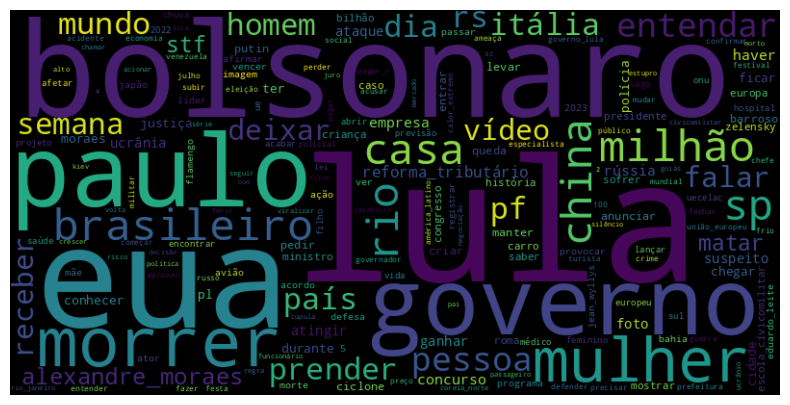

In [ ]:
# Plotar a nuvem de palavras
plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
print('NUVEM DE PALAVRAS MAIS NOTICIADAS NA INTERNET\n')
plt.show()

### 6.3. Nuvem de Palavras Similares

In [ ]:
# Criar dicionário com as frequências das palavras similares à palavra de maior frequência
similar_freq = {}

for i in range(len(similar_words)):
  #similar_freq[i] = {similar_words[i][0]: similar_words[i][1]}
  similar_freq[similar_words[i][0]] = similar_words[i][1]

similar_freq

{'viagem': 0.9996793270111084,
 'senado': 0.9996647834777832,
 'salário': 0.9996639490127563,
 'retorno': 0.9996601343154907,
 'golpe': 0.9996601343154907,
 'alemão': 0.9996597170829773,
 'político': 0.9996590614318848,
 'olho': 0.9996582269668579,
 'porto_alegre': 0.9996578693389893,
 'presidente': 0.9996570348739624,
 'criticar': 0.9996565580368042,
 'partido': 0.9996497631072998,
 'brasil_2023': 0.9996492266654968,
 'cargo': 0.9996487498283386,
 'reunir': 0.9996484518051147}

In [ ]:
# Criar nuvem de palavras com as palavras similares
similar_wordcloud = WordCloud(width = 800, height = 400, background_color = 'black', random_state = 29).generate_from_frequencies(similar_freq)

NUVEM DE PALAVRAS SIMILARES À PALAVRA LULA



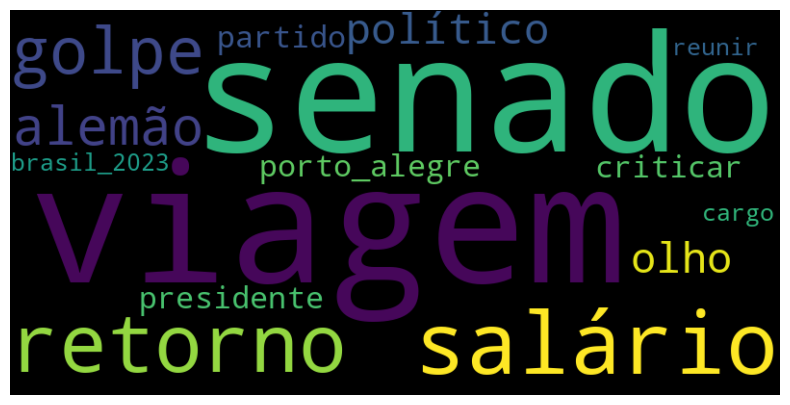

In [ ]:
# Plotar a nuvem de palavras
plt.figure(figsize = (10, 5))
plt.imshow(similar_wordcloud, interpolation = 'bilinear')
plt.axis('off')
print(f'NUVEM DE PALAVRAS SIMILARES À PALAVRA {biggest_word.upper()}\n')
plt.show()